In [62]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import cm
import subprocess
import sys
import scipy
from scipy import interpolate
from scipy import stats
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import matplotlib.animation as animation

sys.path.append('/opt/rtcds/userapps/release/tcs/common/scripts/hws_tools/')
sys.path.append('/ligo/home/daniel.brown/git/hws-binaries/src')

import HS_LIGO_utilities
import HS_Export
import HSM_WFN

In [63]:
import pyctrl
import os
if not os.path.exists('data'):
    os.makedirs('data')

In [64]:
#gps_start= 1225704621
gps_start= 1225714021
duration=3000

fs=4

wit_chan=['TCS-ITMX_CO2_LSRPWR_MTR_OUTPUT', 'TCS-ITMY_CO2_LSRPWR_MTR_OUTPUT',
          'TCS-ITMX_HWS_PROBE_SPHERICAL_POWER','TCS-ITMY_HWS_PROBE_SPHERICAL_POWER',
         'IMC-PWR_IN_OUT16']

In [65]:
pyctrl.fetch_data_nds(gps_start, duration, wit_chan, fs=fs)

fetching data...
fetched!!!
saving data to: data/H1_1225714021_3000.h5
0
TCS-ITMX_CO2_LSRPWR_MTR_OUTPUT
down-sampling to 4.000000 Hz
1
TCS-ITMY_CO2_LSRPWR_MTR_OUTPUT
2
TCS-ITMX_HWS_PROBE_SPHERICAL_POWER
3
TCS-ITMY_HWS_PROBE_SPHERICAL_POWER
4
IMC-PWR_IN_OUT16


In [66]:
wit, __=pyctrl.read_data_multi_chan(gps_start, duration, wit_chan)
t_vect=np.arange(0., duration, 1./fs)

In [67]:
ifo_dict = dict(zip(wit_chan, wit))

(-1e-05, 1e-05)

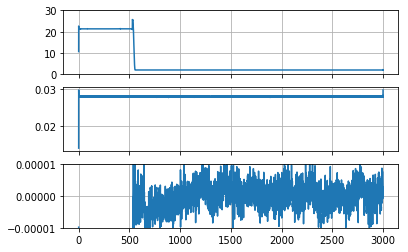

In [68]:
fig=pl.figure()
ax=fig.add_subplot(311)
ax.plot(t_vect, ifo_dict['IMC-PWR_IN_OUT16'])
ax.grid(which='both')
ax.set_ylim([0, 30])
ax.set_xticklabels([])

bx=fig.add_subplot(312)
bx.plot(t_vect, ifo_dict['TCS-ITMX_CO2_LSRPWR_MTR_OUTPUT'])
bx.grid(which='both')
bx.set_xticklabels([])

cx=fig.add_subplot(313)
cx.plot(t_vect, ifo_dict['TCS-ITMX_HWS_PROBE_SPHERICAL_POWER'])
cx.grid(which='both')
cx.set_ylim([-1e-5, 1e-5])

(-4e-05, 1e-05)

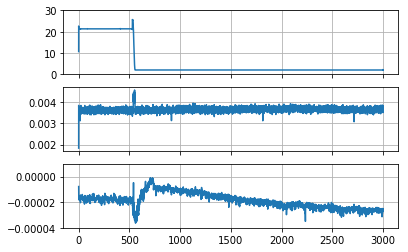

In [69]:
fig=pl.figure()
ax=fig.add_subplot(311)
ax.plot(t_vect, ifo_dict['IMC-PWR_IN_OUT16'])
ax.grid(which='both')
ax.set_ylim([0, 30])
ax.set_xticklabels([])

bx=fig.add_subplot(312)
bx.plot(t_vect, ifo_dict['TCS-ITMY_CO2_LSRPWR_MTR_OUTPUT'])
bx.grid(which='both')
bx.set_xticklabels([])

cx=fig.add_subplot(313)
cx.plot(t_vect, ifo_dict['TCS-ITMY_HWS_PROBE_SPHERICAL_POWER'])
cx.grid(which='both')
cx.set_ylim([-4e-5, 1e-5])

In [70]:
# Get HWS data
subprocess.call('hwsdata')
hws_data_dir = '/h1hwsmsr/data'

ITMX_dict= HS_LIGO_utilities.get_files(gps_start, gps_start+duration,
                                           optic='ITMX', 
                                           data_dir=None, 
                                           ifo=None,  
                                           extension='.p')
ITMY_dict= HS_LIGO_utilities.get_files(gps_start, gps_start+duration, 
                                           optic='ITMY', 
                                           data_dir=None, 
                                           ifo=None,  
                                           extension='.p')

In [71]:
def extract(dictionary):
    grs = []
    imgs = []
    for key,string in dictionary.items():
        export = HS_LIGO_utilities.open_file(dictionary[key])
        grs.append(export.avGradients)
        imgs.append(export.avImage)
    
    grs = np.array(grs)
    imgs = np.array(imgs)

    return grs,imgs

In [72]:
ITMX_grads,ITMX_img = extract(ITMX_dict)
ITMY_grads,ITMY_img = extract(ITMY_dict)

In [73]:
def get_new_SC(imgs,orig):
    ref_cens = HS_LIGO_utilities.get_centroids(imgs[0])
    SCs = []
    keys = ['phi','prism_y','prism_x','prism','cylindrical_power','spherical_power','alpha']
    f = dict.fromkeys(keys)
    for key in f:
        f[str(key)] = []
    for i in range(len(imgs)):
        cens = HS_LIGO_utilities.get_centroids(imgs[i],ref_centroids=ref_cens)
        shifted_grads = HS_LIGO_utilities.get_gradients(ref_cens, cens, origin=orig)
        siedels = HS_LIGO_utilities.get_seidel(shifted_grads)
        for key in f:
            f[str(key)].append(siedels[str(key)])
    return f

In [74]:
ITMX_origin = np.array([700.0, 450.5])
ITMY_origin = np.array([511.5, 511.5])

ITMX_SCs = get_new_SC(ITMX_img,ITMX_origin)
ITMY_SCs = get_new_SC(ITMY_img,ITMY_origin)

In [75]:
ITMX_origin = np.array([700.0, 471.5])

ITMX_shifted_grads = HS_LIGO_utilities.get_gradients(ITMX_ref_cens, ITMX_cens, origin=ITMX_origin)

ITMX_sc = HS_LIGO_utilities.get_seidel(ITMX_shifted_grads)

NameError: name 'spherical_power' is not defined

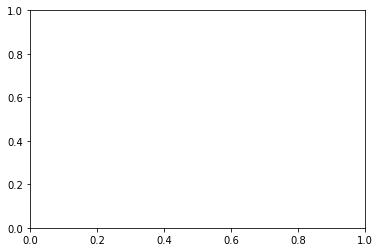

In [76]:
fig=pl.figure()
ax=fig.add_subplot(111)
ax.plot(t_vect, ITMX_sc['spherical_power'])
ax.grid(which='both')
#ax.set_ylim([0, 30])
#ax.set_xticklabels([])

In [ ]:
#Gradients of the reference (start time)
def calculate_grads_wfs(grads_in):
    
    gr_list = []
    wf_list = []
    
    #Loop the input grads
    for i in range(len(grads_in)):

        #Gradient of the current
        hsg = grads_in[i]
        ref = grads_in[0]

        # get the difference in centroids
        U = +hsg[:,0]-ref[:,0]
        V = +hsg[:,1]-ref[:,1]

        #remove tilt
        U = U - np.mean(U)
        V = V - np.mean(V)

        rmsV = scipy.mean(scipy.sqrt(U**2 + V**2))

        # Get the gradients
        limits = {'x': [-0.1, 0.1], 'y': [-0.1, 0.1]}
        spc = 0.2/200.
        x_g,y_g = HSM_WFN.setup_grid(limits,spc)

        cents = hsg[:,2:4]
        grads = np.transpose(np.array([U,V]))

        gr_list.append(grads)

        # calculate the wavefront
        wf = -1E9*HSM_WFN.calculate_wf(cents,grads,limits,spc)
        wf = wf-np.max(wf[50:150,50:150])

        wf_list.append(wf)
        
        #Make the arrays
        wf_array = np.array(wf_list)
        gr_array = np.array(gr_list)
    
    return wf_array,gr_array

In [ ]:
#ITMX_wfs , ITMX_grs = calculate_grads_wfs(ITMX_grads)
#ITMY_wfs , ITMY_grs = calculate_grads_wfs(ITMY_grads)

In [ ]:
ITMX_c_range = np.arange(-60,10,1)
ITMY_c_range = np.arange(-275,10,1)

In [ ]:
def initialize_graphing():
    fig = pl.figure(figsize=(9,5))

    ax1 = fig.add_subplot(121)
    ax1.set_xlim([-0.17, 0.17])
    ax1.set_ylim([-0.17, 0.17])
    ax1.grid()

    acir1, = ax1.plot([], [], 'b-', linewidth=1)
    acir2, = ax1.plot([], [], 'b-', linewidth=1)

    ax2= fig.add_subplot(122)

    ax2.set_xlim([-0.17, 0.17])
    ax2.set_ylim([-0.17, 0.17])
    ax2.grid()

    bcir1, = ax2.plot([], [], 'b-', linewidth=1)
    bcir2, = ax2.plot([], [], 'b-', linewidth=1)
    
    # Make the ITM circle
    cir1, = ax2.plot([], [], 'b-', linewidth=1)
    cir2, = ax2.plot([], [], 'b-', linewidth=1)
    
    theta = np.arange(-np.pi/200, 2*np.pi, np.pi/200)
    xITM = 0.17*np.cos(theta)
    yITM = 0.17*np.sin(theta)
    indEdge = np.where(abs(xITM) > 326.5E-3/2)
    xITM[indEdge] = np.sign(xITM[indEdge])*326.5E-3/2
    cir1.set_data(xITM, yITM)

    xITM = 0.1686 * np.cos(theta)
    yITM = 0.1686 * np.sin(theta)
    indEdge = np.where(abs(xITM) > 326.5E-3/2 - 1.41E-3)
    xITM[indEdge] = np.sign(xITM[indEdge])*(326.5E-3/2-1.41E-3)
    cir2.set_data(xITM, yITM)
    
    return fig, [ax1,ax2]

def plot_wf_quiver(fig,axes,c_range,wfs_in, grs_in, grads_in):
    
    hsg = grads_in
    U = grs_in[:,0]
    V = grs_in[:,1]
    
    ax1=axes[0]
    ax2=axes[1]
    
    ax1.quiver(hsg[:,2], hsg[:,3], U, V, units='x', scale_units='height')
    
    img0= ax2.contourf(x_g,y_g,wfs_in,c_range,cmap='plasma')
    
    cb_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(img0,cax=cb_ax)
    
    img1= ax2.contour(x_g,y_g,wfs_in, colors='k', linewidths=1.3,linestyles='solid')
    

In [ ]:
fig,axes = initialize_graphing()
plot_wf_quiver(fig,axes,ITMX_c_range,ITMX_wfs[-1],ITMX_grs[-1],ITMX_grads[-1])

In [ ]:
fig,axes = initialize_graphing()
plot_wf_quiver(fig,axes,ITMY_c_range,ITMY_wfs[-1],ITMY_grs[-1],ITMY_grads[-1])

In [ ]:
# fig = pl.figure(figsize=(9,5))

# ax1 = fig.add_subplot(121)
# ax1.set_xlim([-0.17, 0.17])
# ax1.set_ylim([-0.17, 0.17])
# ax1.grid()

# acir1, = ax1.plot([], [], 'b-', linewidth=1)
# acir2, = ax1.plot([], [], 'b-', linewidth=1)

# ax2= fig.add_subplot(122)

# ax2.set_xlim([-0.17, 0.17])
# ax2.set_ylim([-0.17, 0.17])
# ax2.grid()

# bcir1, = ax2.plot([], [], 'b-', linewidth=1)
# bcir2, = ax2.plot([], [], 'b-', linewidth=1)

# # Make the ITM circle
# cir1, = ax2.plot([], [], 'b-', linewidth=1)
# cir2, = ax2.plot([], [], 'b-', linewidth=1)

# theta = np.arange(-np.pi/200, 2*np.pi, np.pi/200)
# xITM = 0.17*np.cos(theta)
# yITM = 0.17*np.sin(theta)
# indEdge = np.where(abs(xITM) > 326.5E-3/2)
# xITM[indEdge] = np.sign(xITM[indEdge])*326.5E-3/2
# cir1.set_data(xITM, yITM)

# xITM = 0.1686 * np.cos(theta)
# yITM = 0.1686 * np.sin(theta)
# indEdge = np.where(abs(xITM) > 326.5E-3/2 - 1.41E-3)
# xITM[indEdge] = np.sign(xITM[indEdge])*(326.5E-3/2-1.41E-3)
# cir2.set_data(xITM, yITM)

# anim_axes= [ax1,ax2]

# def plot(i):
#     for coll in ax1.collections: 
#         coll.remove()
#     for coll in ax2.collections: 
#         coll.remove()
#     f = plot_wf_quiver(fig,anim_axes,ITMX_c_range,ITMX_wfs[i],ITMX_grs[i],ITMX_grads[i])
#     return f

# ani = animation.FuncAnimation(fig, plot, interval=500,frames=len(ITMX_grads))
# ani.save('ITMX_new.mp4', extra_args=['-vcodec', 'libx264'], dpi=100)
# HTML(ani.to_html5_video())

In [ ]:
# fig = pl.figure(figsize=(9,5))

# ax1 = fig.add_subplot(121)
# ax1.set_xlim([-0.17, 0.17])
# ax1.set_ylim([-0.17, 0.17])
# ax1.grid()

# acir1, = ax1.plot([], [], 'b-', linewidth=1)
# acir2, = ax1.plot([], [], 'b-', linewidth=1)

# ax2= fig.add_subplot(122)

# ax2.set_xlim([-0.17, 0.17])
# ax2.set_ylim([-0.17, 0.17])
# ax2.grid()

# bcir1, = ax2.plot([], [], 'b-', linewidth=1)
# bcir2, = ax2.plot([], [], 'b-', linewidth=1)

# # Make the ITM circle
# cir1, = ax2.plot([], [], 'b-', linewidth=1)
# cir2, = ax2.plot([], [], 'b-', linewidth=1)

# theta = np.arange(-np.pi/200, 2*np.pi, np.pi/200)
# xITM = 0.17*np.cos(theta)
# yITM = 0.17*np.sin(theta)
# indEdge = np.where(abs(xITM) > 326.5E-3/2)
# xITM[indEdge] = np.sign(xITM[indEdge])*326.5E-3/2
# cir1.set_data(xITM, yITM)

# xITM = 0.1686 * np.cos(theta)
# yITM = 0.1686 * np.sin(theta)
# indEdge = np.where(abs(xITM) > 326.5E-3/2 - 1.41E-3)
# xITM[indEdge] = np.sign(xITM[indEdge])*(326.5E-3/2-1.41E-3)
# cir2.set_data(xITM, yITM)

# anim_axes= [ax1,ax2]

# def plot(i):
#     for coll in ax1.collections: 
#         coll.remove()
#     for coll in ax2.collections: 
#         coll.remove()
#     f = plot_wf_quiver(fig,anim_axes,ITMY_c_range,ITMY_wfs[i],ITMY_grs[i],ITMY_grads[i])
#     return f

# ani = animation.FuncAnimation(fig, plot, interval=500,frames=len(ITMY_grads))
# ani.save('ITMY_new.mp4', extra_args=['-vcodec', 'libx264'], dpi=100)
# HTML(ani.to_html5_video())

In [ ]:
# Comsol model of the self heating
model = np.loadtxt('1W_self_heating_defocus_doublepass.txt')

time_model = model[:,0]
abs_model  = model[:,1]

def TL(x,a,b):    
    y = interpolate.interp1d(time_model,-abs_model/1e6,fill_value="extrapolate")
    ynew = y(x)
    return a + (b * ynew)

a=0.0
b=2.0
x = np.arange(0,2,.001) #hours
f = TL(x,a,b)

#### Plot
pl.figure(figsize=(5, 3), dpi=80)
pl.plot(x,f)
pl.grid()
pl.show()

p_in=17.0
prc_g = 45.0
bs = 0.5
arm_g = 282.0

p_arm = p_in*prc_g*bs*arm_g

#s_indx = 0 + (50*30) #choose a start time a little bit after power down to get a quieter time after lockloss
#e_indx = s_indx + 1*60*45*16  #convert index to seconds (1hour)

s_indx = 650*4
e_indx = len(t_vect)

def get_abs(data,opticname):
    
    time_ix = t_vect[s_indx:e_indx] - t_vect[s_indx]
    data_ix = data[s_indx:e_indx] - data[s_indx]

    time_ix = time_ix/3600
    
    data_start_avg = np.average(data_ix[0:100])#rescale start to zero, guess
    data_ix = data_ix - data_start_avg
    
    [opt,b]=scipy.optimize.curve_fit(TL,time_ix,data_ix)

    arm_abs = 1e9*opt[1]/p_arm #scale to get the absorption in ppm
    print(arm_abs)
    perr = np.sqrt(np.diag(b))
    print(perr)
    
    res = TL(time_ix,opt[0],opt[1])-data_ix
    
    [opt,b]=scipy.optimize.curve_fit(TL,time_ix,data_ix,sigma=1/res)
    
    pl.figure(figsize=(10, 8), dpi=80)
    pl.subplot(211)
    pl.plot(time_ix,data_ix*1e6,label="Data")
    #pl.plot(time_ix,res*1e6,label="Residuals")
    pl.plot(time_ix,TL(time_ix,opt[0],opt[1])*1e6,label="Comsol Model",linewidth=3.0)
    pl.ylabel("Spherical Power (uDiopters)")
    pl.xlabel("Time After Lockloss (Hours)")
    pl.legend()
    #pl.title(opticname + " Abs Estimate = "+str(round(arm_abs,2))+"+/-"+str(round(1e9*rms/p_arm,2)) + "ppb")
    pl.grid()
    
    pl.show()

get_abs(ifo_dict['TCS-ITMX_HWS_PROBE_SPHERICAL_POWER'],'ITMX')

get_abs(ifo_dict['TCS-ITMY_HWS_PROBE_SPHERICAL_POWER'],'ITMY')